# Image alignment with toolbox
***
  
  
Aligning our microscope data is important when we need to make figures or when we are analising things that happen in either channel relative to one another.  The following notebook walks through some of the features of the `toolbox.alignment` and `toolbox.point_fitting` modules. To get started, look at this cat I found in the scikit-image package files, i bet it bites.


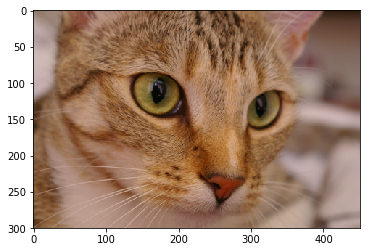

In [12]:
from skimage import data
plt.imshow(data.chelsea(), interpolation='nearest')

In [1]:
from skimage.external.tifffile import imread, imsave
import matplotlib.pyplot as plt
import numpy as np


import toolbox.alignment as al
import toolbox.point_fitting as pt
import toolbox.testdata as test
%matplotlib inline
    


Okay then, now that that's out of the way, I am going to open up one of the test images provided in the `toolbox` package. Then using `im_split` we can display each channel independently

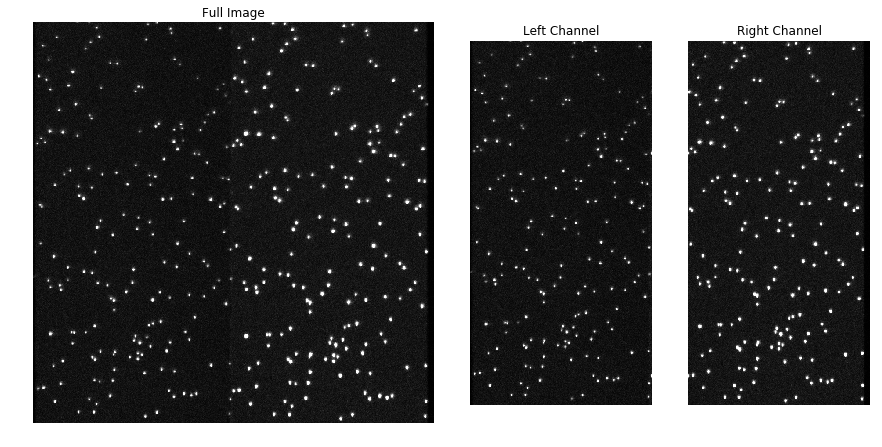

In [14]:
im = test.image_stack()[0]
ch1,ch2 = al.im_split(im)

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=2)
ax1.axis('off')
ax1.set_title("Full Image")
ax1.imshow(im, cmap = "binary_r", vmax = im.max()/2)

ax2 = plt.subplot2grid((1, 4), (0, 2), colspan=1)
ax2.axis('off')
ax2.set_title("Left Channel")
ax2.imshow(ch1, cmap = "binary_r", vmax = im.max()/2)
ax3 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax3.axis('off')
ax3.set_title("Right Channel")
ax3.imshow(ch2, cmap = "binary_r", vmax = im.max()/2)


When we are aligning the two channels, we follow the following steps

1. split the channels 
* locate all of the maxima in both channels
* assign maxima in each channel to each other.
* calculate the absolute distance between corresponding maxima
* then average over several measurements to get a global offset value in x and y

Im going to make explicit some of these steps which are hidden in the package for the most part. We did step 1. above, next lets locate the maxima using the `find_maxima` function for which there is an entire notebook on: https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/finding-local-maxima.ipynb

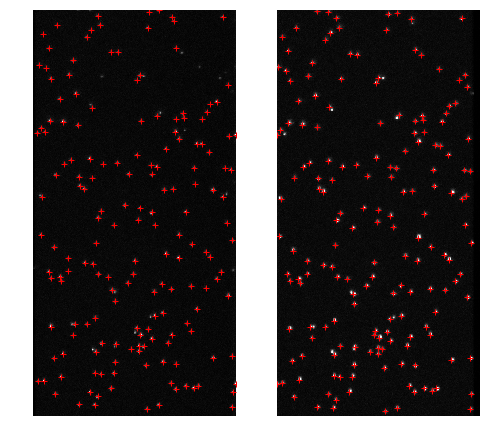

In [17]:
im = test.image_stack()[0]
ch1,ch2 = al.im_split(im)

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(121)
ax1.imshow(ch1,cmap=plt.cm.gray)
ax1.plot(*zip(*pt.find_maxima(ch1,10)), 'r+')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(ch2,cmap=plt.cm.gray)
ax2.plot(*zip(*pt.find_maxima(ch2,10)), 'r+')
ax2.axis('off')
    
im = test.image_stack()[0]

Now lets assign each of these maxima to each other. This step uses `scipy.spatial.cKDTree` to find nearest neighbors in the two maxima lists. This is a bit messy, but the data are cleaned up after this step in two ways.  

First, if any maxima is assigned to more than one corresponding maxima in the other channel, we look to which ever maxima pair are at the smallest distance from one another, we keep that as a maxima pair, and remove the other pairs. Second, we threshold and mean fiter the remaining data. We can see what the assignments look like after doing the first step below.

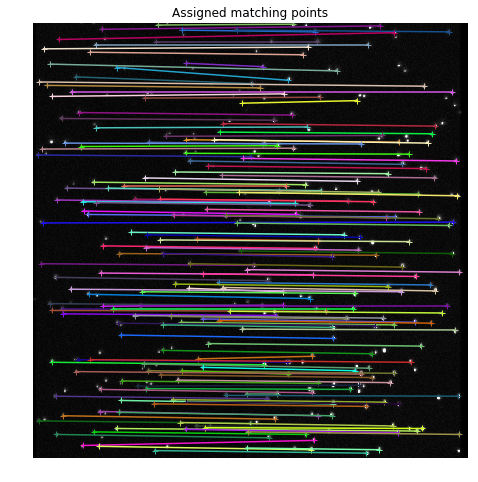

In [4]:
im = test.image_stack()[0]
al.plot_assigned_maxima(im)

It's clear there are some significant mistakes, but by and large, the assignment works. Lets look at this another way though, as a histogram of distances. Note, the distance I mean here is the how far two assigned maxima would be from one another if we overlayed the two channels directly. Additionally, I'm going to use the `get_offset_distribution` function from `toolbox.alignment`, which will also fit each maximum before calculating offset distance.

Text(0.5,0,'individual test images')

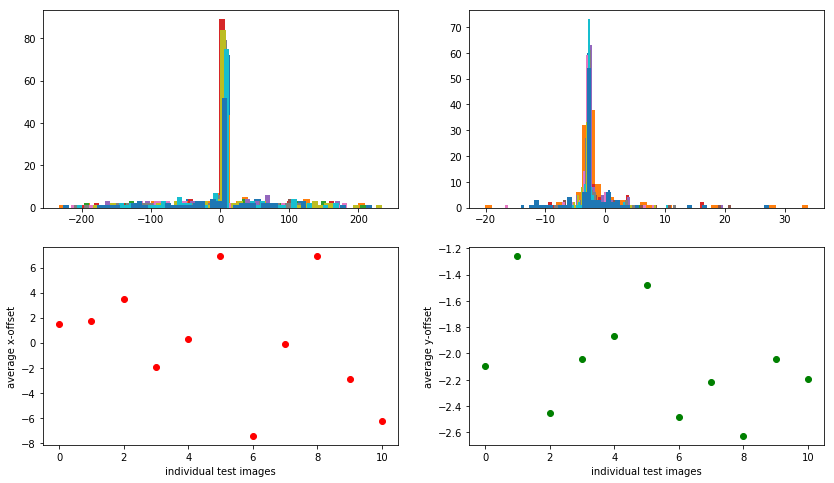

In [5]:
mean_x, mean_y = [],[]
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
for im in test.image_stack():
    xdist,ydist = al.get_offset_distribution(im)
    mean_x.append(np.mean(xdist))
    mean_y.append(np.mean(ydist))
    ax1.hist(xdist,50)
    ax2.hist(ydist,50)

ax3 = fig.add_subplot(223)  
ax3.plot(mean_x,"ro")
ax3.set_ylabel("average x-offset")
ax3.set_xlabel("individual test images")
ax4 = fig.add_subplot(224)
ax4.plot(mean_y,"go")
ax4.set_ylabel("average y-offset")
ax4.set_xlabel("individual test images")


Again, it's pretty clear that there is a dominant offset value, which means our left and right channel assignments are pretty good. However, it is also pretty clear there is a significant background population, and that population is dominating our estimation of mean offset in both x and y, although its way worse in x. 

I thought a fair amount about how to remove this background population in a way that would run unsupervised and wouldn't bias the outcomes, and I'm not sure whether we've hit the best solution yet, but for now I've settled on the function `scrub_outliers`, which is a two step process. First, the data are binned into a histogram using `FD_rule_bins`. I then only keep values from the top couple of bins, usually ~60% of the data. Second, I remove any value remaining that is more than two standard deviations away from the mean, this typically removes < 5% of the remaining values. To see how this changes the outcomes, I have replotted the above graphs after scrubbing.

percent change in x and y distributions post-scrub:  42 50
percent change in x and y distributions post-scrub:  41 43
percent change in x and y distributions post-scrub:  51 39
percent change in x and y distributions post-scrub:  55 41
percent change in x and y distributions post-scrub:  48 56
percent change in x and y distributions post-scrub:  34 47
percent change in x and y distributions post-scrub:  58 40
percent change in x and y distributions post-scrub:  40 57
percent change in x and y distributions post-scrub:  32 41
percent change in x and y distributions post-scrub:  53 46
percent change in x and y distributions post-scrub:  48 36


Text(0.5,0,'individual test images')

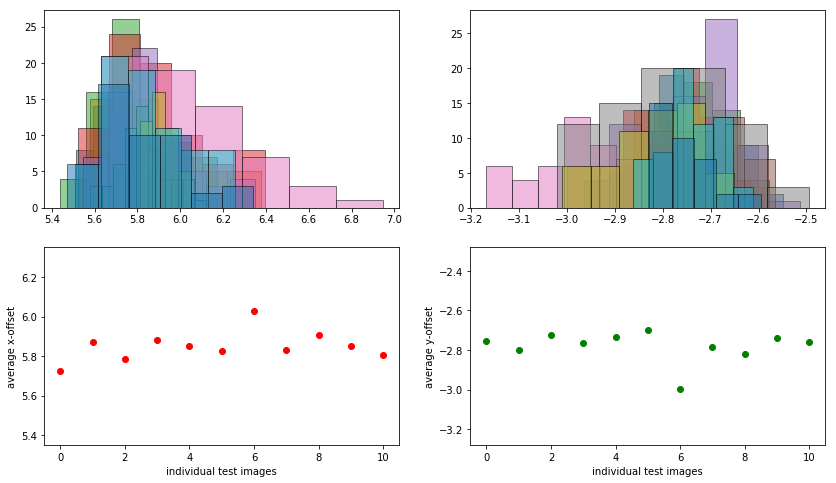

In [6]:
mean_x, mean_y = [],[]
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(221)  
ax2 = fig.add_subplot(222)  
for im in test.image_stack():
    xdist,ydist = al.get_offset_distribution(im)
    scrubbed_x = al.scrub_outliers(xdist)
    scrubbed_y = al.scrub_outliers(ydist)
    print("percent change in x and y distributions post-scrub: ",
          int((len(scrubbed_x)/len(xdist))*100),
          int((len(scrubbed_y)/len(ydist))*100))
    mean_x.append(np.mean(scrubbed_x))
    mean_y.append(np.mean(scrubbed_y))
    
    ax1.hist(scrubbed_x,al.FD_rule_bins(scrubbed_x),ec = 'k',alpha = .5)
    ax2.hist(scrubbed_y,al.FD_rule_bins(scrubbed_y),ec = 'k',alpha = .5)

ax3 = fig.add_subplot(223)  
ax3.plot(mean_x,"ro")
ax3.set_ylim(np.mean(mean_x)-.5,np.mean(mean_x)+.5)
ax3.set_ylabel("average x-offset")
ax3.set_xlabel("individual test images")
ax4 = fig.add_subplot(224)
ax4.plot(mean_y,"go") 
ax4.set_ylim(np.mean(mean_y)-.5,np.mean(mean_y)+.5)
ax4.set_ylabel("average y-offset")
ax4.set_xlabel("individual test images")

So maybe our assignment algorithm could be better because we do have about 40% misasignment. But to be fair much of this may be due to maxima that were found by the `find_maxima` function in `toolbox.point_fitting` in one channel, but the corresponding maxima was not found in the other channel and that coupled with not allowing multiple maxima to be assigned to the same maximum is likely confounding. Altogether though, the process seems to work pretty well and for even a single image, we are able to assign the offset to sub pixel values. 

It is important though to realise, that there may still be some significant error in any individual measurment. For example, image 6 deviates more than the other images in both x and y. While that amount of deviation really won't make much of a difference when we are just overlaying channels to make pretty pictures, it is too much error if we are trying to say something about colocalization of two signals in separate channels. For that, we would like to average over several of these measurments to get a global idea of the offsets with high confidence. To do that, we pool each of the individual scrubbed distributions into a single distribution and fit the mean.

displacements in x
norm fit moments:  (5.854060490393079, 0.19597250295087804)
skewnorm fit moments:  (3.7477239688745385, 5.624042070667237, 0.3021824629624271)
displacements in y
norm fit moments:  (-2.776417751994417, 0.10890981022413028)
skewnorm fit moments:  (-3.0517207126244887, -2.651128775580636, 0.1660072054897307)


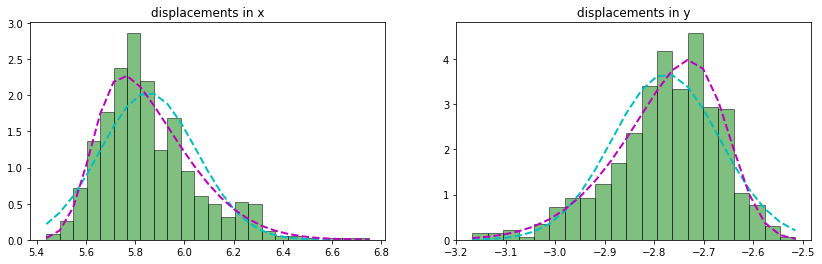

In [7]:
from scipy.stats import norm,skewnorm
import matplotlib.mlab as mlab
pooled_x, pooled_y = [],[]
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)  
ax2 = fig.add_subplot(122)  

for im in test.image_stack():
    xdist,ydist = al.get_offset_distribution(im)
    pooled_x+=al.scrub_outliers(xdist)   
    pooled_y+=al.scrub_outliers(ydist)   

n1,bins1,patches1 = ax1.hist(pooled_x,al.FD_rule_bins(pooled_x), normed=1, fc = "g",ec = "k",alpha = .5)
n2,bins2,patches2 = ax2.hist(pooled_y,al.FD_rule_bins(pooled_y), normed=1, fc = "g",ec = "k",alpha = .5)

moments_norm = norm.fit(pooled_x)
moments_skew = skewnorm.fit(pooled_x)
ax1.plot(bins1, norm.pdf(bins1,*moments_norm), 'c--', linewidth=2)
ax1.plot(bins1, skewnorm.pdf(bins1,*moments_skew), 'm--', linewidth=2)
ax1.set_title("displacements in x")
print("displacements in x")
print("norm fit moments: ",moments_norm)
print("skewnorm fit moments: ",moments_skew)
moments_norm = norm.fit(pooled_y)
moments_skew = skewnorm.fit(pooled_y)
ax2.plot(bins2, norm.pdf(bins2,*moments_norm), 'c--', linewidth=2)
ax2.plot(bins2, skewnorm.pdf(bins2,*moments_skew), 'm--', linewidth=2)
ax2.set_title("displacements in y")
print("displacements in y")
print("norm fit moments: ",moments_norm)
print("skewnorm fit moments: ",moments_skew)

First of all, the distributions look relatively good, but notice that we have picked up a skew in both channels. Before we discuss the skew in the data, let me make a point about what this distribution means: **That if one were to do an experiment, first aligning the data with an equivalent data set to the one used here, the limit of our ability to say two points are in the same place in separate channels is ~0.2 pixels, or ~50nm**. Thats actually pretty good, but we can do better, which will be the subject of a later document. 


Back to the skew. At this time, I do not now the origin of this. It could be a specific issue with the test data used to build the `toolbox` functions, it could be inherent in the functions themselves, it could be optical on the microscope, or a real product of the data manipulations we are doing. To check on the idea that it has to do with the microscope, I'm going to plot the measured offset relative to it's position in the image.   

In the plot below, 
* lighter colors are larger offsets, darker colors are smaller
* x-offsets are plotted on the left, y-offsets on the right.

We are looking for spatial organization of shades of colors, for example, are all of the light colors (high values) clustered together in a corner.

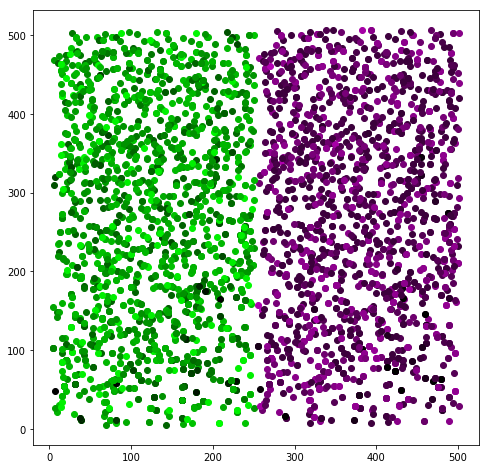

In [8]:
from scipy.spatial import cKDTree

def offset_and_position(Image):
    ch1,ch2 = al.im_split(Image)
    ch1_maxima = pt.find_maxima(ch1,10)
    ch2_maxima = pt.find_maxima(ch2,10)
    x_data,y_data = [],[]
    mytree = cKDTree(ch1_maxima)
    dist, indexes = mytree.query(ch2_maxima)
    for i in range(len(ch2_maxima)):
        x1, y1 = ch1_maxima[indexes[i]]
        x2, y2 = ch2_maxima[i]
        fit_ch1 = pt.fit_routine(ch1, x1, y1, 9)
        fit_ch2 = pt.fit_routine(ch2, x2, y2, 9)
        try:
            x_data.append((x1,y1,fit_ch1[1]-fit_ch2[1]))
            y_data.append((x1,y1,fit_ch1[2]-fit_ch2[2]))
        except TypeError:
            pass
    return x_data,y_data
     
    
global_dx,global_dy = al.find_global_offset(test.image_stack())
    
fig = plt.figure(figsize=(8,8))
for im in test.image_stack():
    x_data,y_data = offset_and_position(im)
    xoff = [offset for x,y,offset in x_data]
    yoff = [offset for x,y,offset in y_data]

    for x,y,offset in x_data:     
        scaled_x_offset = (offset-min(xoff))/(max(xoff)-min(xoff))
        plt.plot(x,y,color = (0.,scaled_x_offset, 0.), marker = 'o')

    for x,y,offset in y_data:  
        x=x+256-global_dx
        y=y-global_dy
        scaled_y_offset = (offset-min(yoff))/(max(yoff)-min(yoff))
        plt.plot(x,y,color = (scaled_y_offset, 0.,scaled_y_offset), marker = 'o')
    

It doesn't seem obvious that there is a bias, but we can plot this data another way to check. Plotted as scatters where we plot offsets against their (x,y) positions.

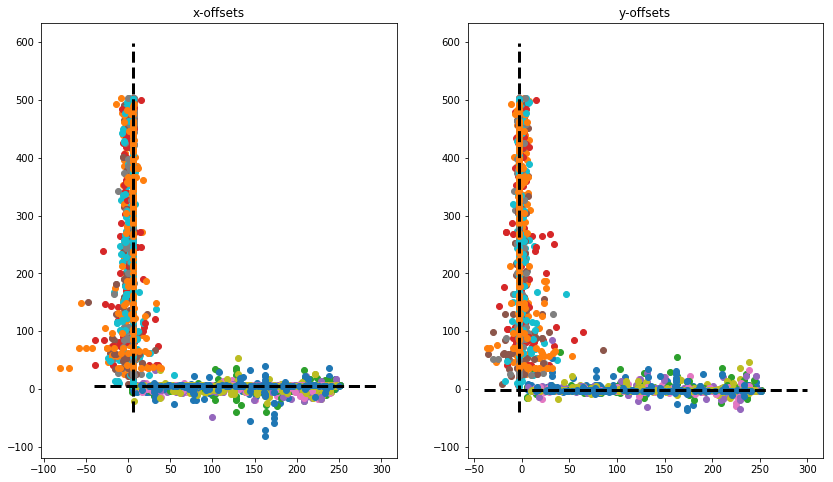

In [9]:

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)  
ax2 = fig.add_subplot(122,sharey=ax1)

for im in test.image_stack():
    x_data,y_data = offset_and_position(im)
    xx,xy,xoff = zip(*x_data)
    yx,yy,yoff = zip(*y_data)
    ax1.scatter(xx,xoff)
    ax1.scatter(xoff,xy)
    ax2.scatter(yx,yoff)
    ax2.scatter(yoff,yy)

    
X = [i for i in np.arange(-40,300,1)]
Y = [i for i in np.arange(-40,600,1)]
global_dx,global_dy = al.find_global_offset(test.image_stack())
ax1.set_title("x-offsets")
ax1.plot(X,[global_dx for i in X],"k--",linewidth = 3)
ax1.plot([global_dx for i in Y],Y,"k--",linewidth = 3)
ax2.set_title("y-offsets")
ax2.plot(X,[global_dy for i in X],"k--",linewidth = 3)
ax2.plot([global_dy for i in Y],Y,"k--",linewidth = 3)

Again, not super obvious that there is bias, although you could make a claim that both the x- and y-offsets near the origin in the y-dimension are noisier, and that might merit looking into.

Moving forward though, we are going to use the mean of our fit from the the above pooled data to determine the global average offset in x and y. To be clear, I am assigning the mean as the mean from the `skewnorm.fit` and using the `find_global_offset` function in `toolbox.alignment`.

In [10]:
global_dx,global_dy = al.find_global_offset(test.image_stack())
print(global_dx,global_dy)

5.624042070667237 -2.651128775580636


As a final bit, I expect a common use of this will be to align to images for a figure. The `toolbox.alignment` module has a function for that also, `align_by_offset`. Additionally, I am going to use a function `overlay`, which does the work of converting to a two color RGB image with green and magenta. 

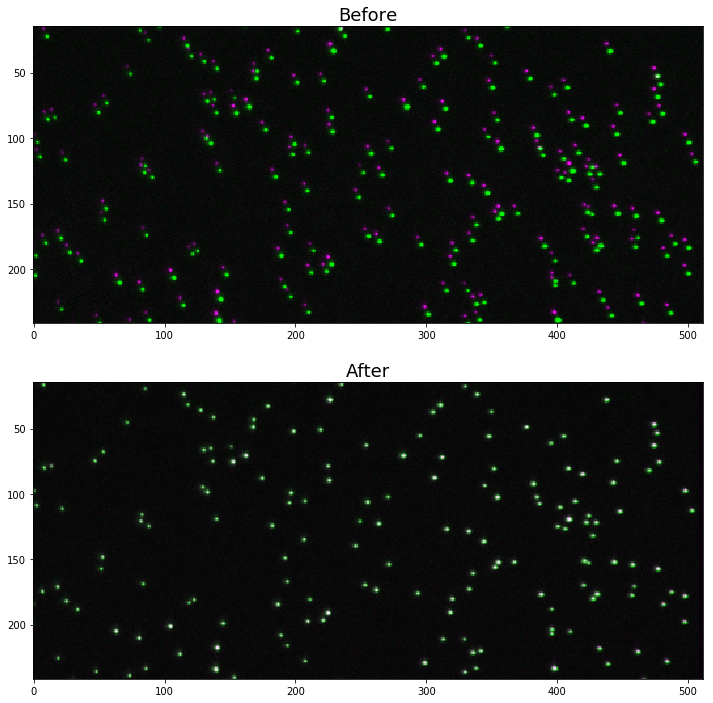

In [24]:
im = test.image_stack()[0]
adj_image = al.align_by_offset(im,global_dx,global_dy)
im_old = al.overlay(im)
im_new = al.overlay(adj_image)
    
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)  
ax2 = fig.add_subplot(212,sharex=ax1)
ax1.set_title('Before', fontsize = "18")
ax2.set_title('After', fontsize = "18")
ax1.imshow(im_old)
ax2.imshow(im_new)

#if you wanted to save to file use this:
#imsave('outfile_name.tif', im_new) 

